<a href="https://colab.research.google.com/github/pranav-modh/Coding-Challenge---Athinia/blob/main/Coding_Challenge_Athinia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Requirements

In [ ]:
!pip3 install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, year, month, lower, when, lit, count, min, max, avg, col, corr, mean
from pyspark.sql.types import DateType
from pyspark.sql import functions as F, DataFrameStatFunctions
from scipy.stats import ttest_ind, ranksums

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
# Create Spark Session

spark = SparkSession.builder \
    .appName("Athinia Challenge") \
    .getOrCreate()

# AQI Data Exploration

## Load AQI Data From Drive And Merge It

In [ ]:
# Load each year file and concat it into single dataframe

aqi_data = pd.read_csv(f"/content/drive/MyDrive/Athinia/AQI_data/daily_aqi_by_county_1980.csv")

for year in tqdm(range(1981, 2022)):
  year = str(year)
  filename = f"daily_aqi_by_county_{year}.csv"
  temp_df = pd.read_csv(f"/content/drive/MyDrive/Athinia/AQI_data/{filename}")
  aqi_data = pd.concat([aqi_data, temp_df], ignore_index=True)


## AQI Data Exploration

In [ ]:
# Rename columns to the meaningful names and also make everything lowercased for making it easy to work with

aqi_data = aqi_data.rename(columns={'State Name': 'state_name', 'county Name': 'county_name', 'State Code': 'state_code', 'County Code': 'county_code', 'Date': 'date', 'AQI': 'aqi',
       'Category': 'category', 'Defining Parameter': 'defining_parameter', 'Defining Site': 'defining_site',
       'Number of Sites Reporting': 'number_of_sites_reporting'})

aqi_data.columns

In [ ]:
# remove Canada as state as we are currently doing analysis of only United States

aqi_data = aqi_data[aqi_data.state_code != 'CC']

In [ ]:
# Change datatype to appropriate datatype so that it is easy for manipulation and take less memory space

print("AQI Datatypes before changes: ")
print(aqi_data.dtypes)

aqi_data.loc[:,'state_code'] = aqi_data['state_code'].astype('int')
aqi_data.loc[:, 'category'] = aqi_data['category'].astype('category')
aqi_data.loc[:, 'state_name'] = aqi_data['state_name'].astype('string')
aqi_data.loc[:, 'county_name'] = aqi_data['county_name'].astype('string')
aqi_data.loc[:, 'defining_site'] = aqi_data['defining_site'].astype('string')
aqi_data.loc[:,'defining_parameter'] = aqi_data['defining_parameter'].astype('category')
aqi_data['date'] = pd.to_datetime(aqi_data['date'])

print("AQI Datatypes after changes: ")
print(aqi_data.dtypes)

In [ ]:
# lower case all the string data

aqi_data['state_name'] = aqi_data['state_name'].str.lower()
aqi_data['county_name'] = aqi_data['county_name'].str.lower()
aqi_data['defining_site'] = aqi_data['defining_site'].str.lower()
aqi_data['category'] = aqi_data['category'].str.lower()

In [ ]:
# No missing values found in the data

aqi_data = aqi_data.replace(['missing', 'na', 'null', 'unknown'], value=float('nan'))
aqi_data.isna().sum()

# Covid Data Exploration

## Load Covid-19 (cases) data from csv into PySpark

In [ ]:
url_data = "/content/drive/MyDrive/Athinia/cases.csv"
loaded_data = "/content/drive/MyDrive/Athinia/cases_data.csv"

In [ ]:
# Create Spark session and pass data url for data loading
cases_data = spark.read \
    .format("csv") \
    .option("header", "true") \
    .load(loaded_data)

## Data Pre Processing

In [ ]:
# Check values of hospitalization column

cases_data.groupBy("hosp_yn").agg(count("*").alias("count")).show()

+-------+--------+
|hosp_yn|   count|
+-------+--------+
|   null|18531565|
|     no|14848870|
|    yes| 1590353|
+-------+--------+



In [ ]:
cases_data = cases_data.withColumn("case_month", to_date(cases_data["case_month"], 'yyyy-MM'))
cases_data = cases_data.withColumn("year", year(cases_data["case_month"]))
cases_data = cases_data.withColumn("month", month(cases_data["case_month"]))

In [ ]:
# Make all the string dtype column values in lower case
column_names = [
    "res_state",
    "res_county",
    "age_group",
    "sex",
    "race",
    "ethnicity",
    "underlying_conditions_yn",
    "death_yn",
    "icu_yn",
    "hosp_yn",
    "symptom_status",
    "current_status",
    "process"
]
for column in column_names:
    cases_data = cases_data.withColumn(column, lower(cases_data[column]))


In [ ]:
# Add state name to abbrevation

state_code_map = pd.read_csv('/content/data.csv')
state_code_map['state'] = state_code_map['state'].str.lower()
state_code_map['code'] = state_code_map['code'].str.lower()
state_code_map.drop(columns='abbrev', inplace=True)

state_code_map_lst = []
for idx,row in enumerate(state_code_map.iterrows()):
  row = row[1]
  state_code_map_lst.append((idx, row['state'], row['code']))


state_code_map = spark.createDataFrame(state_code_map_lst, ["code", "state_name", "state_code"])


joined_df = cases_data.join(state_code_map, cases_data["res_state"] == state_code_map["state_code"], "left")


final_df = joined_df.select(cases_data["*"], state_code_map["state_name"])


cases_data = final_df.withColumnRenamed("state_name", "state")

cases_data.show()
del final_df
del joined_df
del state_code_map

+----------+---------+---------------+----------+----------------+--------------+------+-------+---------+-------------------------------+-------------------+-------------------+-----------+--------------------+--------------+-------+-------+--------+------------------------+----+-----+--------------+
|case_month|res_state|state_fips_code|res_county|county_fips_code|     age_group|   sex|   race|ethnicity|case_positive_specimen_interval|case_onset_interval|            process|exposure_yn|      current_status|symptom_status|hosp_yn| icu_yn|death_yn|underlying_conditions_yn|year|month|         state|
+----------+---------+---------------+----------+----------------+--------------+------+-------+---------+-------------------------------+-------------------+-------------------+-----------+--------------------+--------------+-------+-------+--------+------------------------+----+-----+--------------+
|2020-11-01|       il|             17|   clinton|           17027|18 to 49 years|female|mis

In [ ]:
# Get a DataFrame indicating whether each cell is null or not
null_df = cases_data.select([F.when(F.col(c).isNull(), 1).otherwise(0).alias(c) for c in cases_data.columns])

# Get the number of null values in each column
null_counts = null_df.agg(*[F.sum(c).alias(c) for c in null_df.columns])

null_counts.show()
del null_df

+----------+---------+---------------+----------+----------------+---------+---+----+---------+-------------------------------+-------------------+-------+-----------+--------------+--------------+-------+------+--------+------------------------+----+-----+-----+
|case_month|res_state|state_fips_code|res_county|county_fips_code|age_group|sex|race|ethnicity|case_positive_specimen_interval|case_onset_interval|process|exposure_yn|current_status|symptom_status|hosp_yn|icu_yn|death_yn|underlying_conditions_yn|year|month|state|
+----------+---------+---------------+----------+----------------+---------+---+----+---------+-------------------------------+-------------------+-------+-----------+--------------+--------------+-------+------+--------+------------------------+----+-----+-----+
|        12|        0|              0|         0|               0|        0|  0|   0|        0|                       25113195|           20221411|      0|          0|             0|             0|      0|   

In [ ]:
# remove values having null in case month
cases_data = cases_data.dropna(subset=['case_month'])

In [ ]:
null_rows = cases_data.filter(cases_data.state.isNull())

null_rows.show()
distinct_names = null_rows.select("res_state").distinct().show()

# remove rows having res_state as "na" values
cases_data = cases_data.filter(cases_data.res_state != "na")
distinct_names = cases_data.select("res_state").distinct().show()
del distinct_names
del null_rows

+----------+---------+---------------+----------+----------------+------------+------+-----+---------------+-------------------------------+-------------------+--------------------+-----------+--------------------+--------------+-------+-------+--------+------------------------+----+-----+-----+
|case_month|res_state|state_fips_code|res_county|county_fips_code|   age_group|   sex| race|      ethnicity|case_positive_specimen_interval|case_onset_interval|             process|exposure_yn|      current_status|symptom_status|hosp_yn| icu_yn|death_yn|underlying_conditions_yn|year|month|state|
+----------+---------+---------------+----------+----------------+------------+------+-----+---------------+-------------------------------+-------------------+--------------------+-----------+--------------------+--------------+-------+-------+--------+------------------------+----+-----+-----+
|2021-08-01|       vi|             78|        na|              NA|0 - 17 years|female|black|hispanic/latino| 

In [ ]:
# Added state names which were not in the mapping sheet using google
distinct_names_map = {
    'vi': 'virgin islands',
    'pr': 'puerto rico',
    'gu': 'guam'
}
for code, name in distinct_names_map.items():
    cases_data = cases_data.withColumn("state", when(cases_data["res_state"] == code, name).otherwise(cases_data["state"]))
cases_data.show()

+----------+---------+---------------+----------+----------------+--------------+------+-------+---------+-------------------------------+-------------------+-------------------+-----------+--------------------+--------------+-------+-------+--------+------------------------+----+-----+--------------+
|case_month|res_state|state_fips_code|res_county|county_fips_code|     age_group|   sex|   race|ethnicity|case_positive_specimen_interval|case_onset_interval|            process|exposure_yn|      current_status|symptom_status|hosp_yn| icu_yn|death_yn|underlying_conditions_yn|year|month|         state|
+----------+---------+---------------+----------+----------------+--------------+------+-------+---------+-------------------------------+-------------------+-------------------+-----------+--------------------+--------------+-------+-------+--------+------------------------+----+-----+--------------+
|2020-11-01|       il|             17|   clinton|           17027|18 to 49 years|female|mis

In [ ]:
null_rows = cases_data.filter(cases_data.state.isNull())
distinct_names = null_rows.select("res_state").distinct().show()

+---------+
|res_state|
+---------+
+---------+



In [ ]:
cases_data = cases_data.withColumnRenamed("state", "state_name")
cases_data = cases_data.withColumnRenamed("res_county", "county_name")
cases_data = cases_data.withColumnRenamed("case_month", "date")

In [ ]:
cases_data.select(col("age_group")).distinct().show()

+--------------+
|     age_group|
+--------------+
|18 to 49 years|
|  0 - 17 years|
|       missing|
|50 to 64 years|
|     65+ years|
|            na|
+--------------+



In [ ]:
cases_data = cases_data.na.replace("missing", None).na.replace("unknown", None).na.replace("na", None)

# Get a DataFrame indicating whether each cell is null or not
null_df = cases_data.select([F.when(F.col(c).isNull(), 1).otherwise(0).alias(c) for c in cases_data.columns])

# Get the number of null values in each column
null_counts = null_df.agg(*[F.sum(c).alias(c) for c in null_df.columns])

null_counts.show()
del null_df

+----+---------+---------------+-----------+----------------+---------+-------+--------+---------+-------------------------------+-------------------+--------+-----------+--------------+--------------+--------+--------+--------+------------------------+----+-----+----------+
|date|res_state|state_fips_code|county_name|county_fips_code|age_group|    sex|    race|ethnicity|case_positive_specimen_interval|case_onset_interval| process|exposure_yn|current_status|symptom_status| hosp_yn|  icu_yn|death_yn|underlying_conditions_yn|year|month|state_name|
+----+---------+---------------+-----------+----------------+---------+-------+--------+---------+-------------------------------+-------------------+--------+-----------+--------------+--------------+--------+--------+--------+------------------------+----+-----+----------+
|   0|        0|              0|    2560364|               0|   760752|1524652|14733931| 17399081|                       25112556|           20220802|35711055|          0| 

In [ ]:
# Remove Column which are not having any county name
cases_data = cases_data.filter(cases_data['county_name'].isNotNull())

null_df = cases_data.select([F.when(F.col('county_name').isNull(), 1).otherwise(0).alias("county_name")])

# Get the number of null values in each column
null_counts = null_df.agg(*[F.sum("county_name").alias("county_name")])

null_counts.show()
del null_df

+-----------+
|county_name|
+-----------+
|          0|
+-----------+



In [ ]:
# Most Common group Imputation on Age group

# First, find the most common group of the "age_group" column
age_group_count = cases_data.groupBy("age_group").agg(count("*").alias("count"))
max_count = age_group_count.agg(F.max("count")).collect()[0][0]

# Replace missing values in the "age_group" column with the calculated mean
cases_data = cases_data.na.fill({ "age_group": max_count})

null_df = cases_data.select([F.when(F.col('age_group').isNull(), 1).otherwise(0).alias("age_group")])

# Get the number of null values in each column
null_counts = null_df.agg(*[F.sum("age_group").alias("age_group")])

null_counts.show()
del null_df
del age_group_count


+---------+
|age_group|
+---------+
|        0|
+---------+



In [ ]:
cases_data = cases_data.withColumn("age_group", when(cases_data["age_group"] == 18384803, '18-49 years')\
              .when(cases_data["age_group"] == '18384803', '18-49 years')\
              .when(cases_data["age_group"] == '0 - 17 years', '0-17 years')\
              .when(cases_data["age_group"] == '50 to 64 years', '50-64 years')\
              .when(cases_data["age_group"] == "18 to 49 years", '18-49 years')
              .otherwise(cases_data["age_group"]))

cases_data.select(col("age_group")).distinct().show()

+-----------+
|  age_group|
+-----------+
|18-49 years|
| 0-17 years|
|  65+ years|
|50-64 years|
+-----------+



In [ ]:
for column in cases_data.columns:
    cases_data = cases_data.filter(~(F.col(column).isin("nul")))

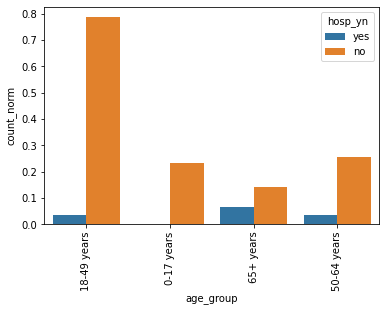

In [ ]:
# Relation between age group and Hospitalization rate
from sklearn.preprocessing import MinMaxScaler

grouped_data = cases_data.groupBy(['age_group', 'hosp_yn'])
count_data = grouped_data.count()
pd_data = count_data.toPandas()

scaler = MinMaxScaler()

scaler.fit(pd_data[['count']])

pd_data['count_norm'] = scaler.transform(pd_data[['count']])

sns.barplot(x='age_group',y='count_norm', hue='hosp_yn', data=pd_data)

plt.xticks(rotation=90)

plt.show()



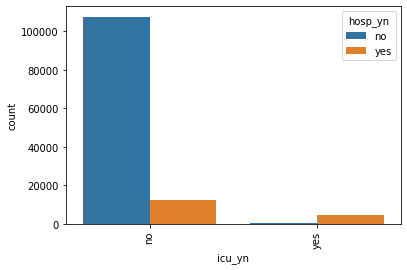

In [ ]:
# Relation between icu and Hospitalization rate

grouped_data = cases_data.groupBy(['icu_yn', 'hosp_yn'])
count_data = grouped_data.count()
pd_data = count_data.toPandas()

sns.barplot(x='icu_yn',y='count', hue='hosp_yn', data=pd_data)

plt.xticks(rotation=90)

plt.show()


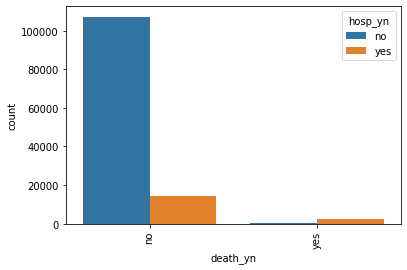

In [ ]:
# Relation between death and Hospitalization rate

grouped_data = cases_data.groupBy(['death_yn', 'hosp_yn'])
count_data = grouped_data.count()
pd_data = count_data.toPandas()

sns.barplot(x='death_yn',y='count', hue='hosp_yn', data=pd_data)

plt.xticks(rotation=90)

plt.show()

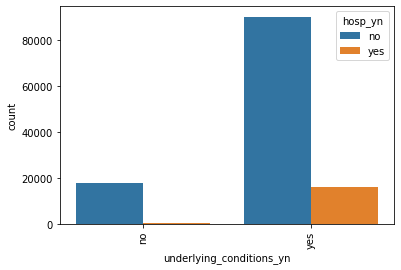

In [ ]:
# Relation between Known conditions and Hospitalization rate

grouped_data = cases_data.groupBy(['underlying_conditions_yn', 'hosp_yn'])
count_data = grouped_data.count()
pd_data = count_data.toPandas()

sns.barplot(x='underlying_conditions_yn',y='count', hue='hosp_yn', data=pd_data)

plt.xticks(rotation=90)

plt.show()

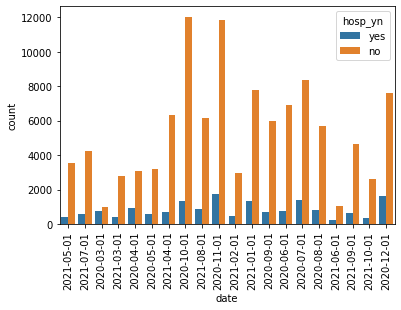

In [ ]:
# Relation between date and Hospitalization rate

grouped_data = cases_data.groupBy(['date', 'hosp_yn'])
count_data = grouped_data.count()
pd_data = count_data.toPandas()

sns.barplot(x='date',y='count', hue='hosp_yn', data=pd_data)

plt.xticks(rotation=90)

plt.show()

In [ ]:
sampled_df = cases_data.sample(False, 0.1, seed=42)
columns = ["icu_yn", "death_yn", "underlying_conditions_yn", 'sex', 'hosp_yn']
pd_data = sampled_df.select(columns)

pd_data = pd_data.toPandas()

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

df = pd_data

X = df.drop('hosp_yn', axis=1)
y = df['hosp_yn']

le = LabelEncoder()
X = X.apply(le.fit_transform)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = clf.score(X_test, y_test)
print("Accuracy: ", accuracy)


Accuracy:  0.8981744421906693


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, lit
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
import numpy as np
import pickle
from pyspark.sql.functions import monotonically_increasing_id

hosp_yn_null_data = cases_data.filter(isnan(cases_data.hosp_yn) | (cases_data.hosp_yn.isNull()))
hosp_yn_null_data = hosp_yn_null_data.withColumn("id", monotonically_increasing_id())

for idx,start_idx in tqdm(enumerate(range(0,cases_data.count(), 25000))):
    try:
        sec = hosp_yn_null_data.filter((col("id") >= start_idx) & (col("id") <= start_idx + 25000))
        sec = sec.toPandas()
        df_features = sec[["icu_yn", "death_yn", "underlying_conditions_yn", "sex"]]

        le = LabelEncoder()
        df_features = df_features.apply(le.fit_transform)

        y_pred = clf.predict(df_features)


        sec["hosp_yn"] = y_pred
        if idx == 0:
            predict_df = spark.createDataFrame(sec)
        else:
            new_df = spark.createDataFrame(sec)
            predict_df = predict_df.union(new_df)
    except Exception as e:
        print(e)
        print(start_idx)

cases_data = cases_data.union(predict_df)

In [ ]:
# Fill Null values sex

from pyspark.sql import functions as F

# Calculate the mode of the "sex" column

mode = cases_data.filter(F.col("sex").isNotNull()).groupby("sex").count().orderBy("count", ascending=False).first()[0]

# Impute the missing values with the mode
cases_data = cases_data.na.fill(mode, subset=["sex"])


In [ ]:
from pyspark.sql import functions as F

# Fill Null values ethnicity


# Calculate the mode of the "ethnicity" column

mode = cases_data.filter(F.col("ethnicity").isNotNull()).groupby("ethnicity").count().orderBy("count", ascending=False).first()[0]

# Impute the missing values with the mode
cases_data = cases_data.na.fill(mode, subset=["ethnicity"])


# Analysis

## Question 1: Air Quality index and impact of lockdown

In [ ]:
# Create a new column named Lockdown and add month and year columns based on date column

aqi_data['lockdown'] = 0
aqi_data['month'] = aqi_data.date.dt.month
aqi_data['year'] = aqi_data.date.dt.year

In [ ]:
# Create a new dataframe containing data from march of each year to the August of each year as lockdown was imposed between this month in year 2020 in United States.

que_1_df = aqi_data[(aqi_data['month'] >= 3) & (aqi_data['month'] <= 8) & (aqi_data['year'] <= 2021)]

# Add 1 (true) in lockdown for year 2020 and 0 (false) for other years.
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8782469/#:~:text=In%20the%20beginning%20of%20the,policy%20measures%20in%20the%20US.

que_1_df['lockdown'] = np.where(que_1_df['year'] == 2020, 1, 0)
que_1_df.head(5)

<ipython-input-23-90b0c15f0f88>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  que_1_df['lockdown'] = np.where(que_1_df['year'] == 2020, 1, 0)


,state_name,county_name,state_code,county_code,date,aqi,category,defining_parameter,defining_site,number_of_sites_reporting,lockdown,month,year
0,alabama,autauga,1,1,1980-04-05,67,moderate,Ozone,01-001-0002,1,0,4,1980
1,alabama,autauga,1,1,1980-04-06,84,moderate,Ozone,01-001-0002,1,0,4,1980
2,alabama,autauga,1,1,1980-04-07,61,moderate,Ozone,01-001-0002,1,0,4,1980
3,alabama,autauga,1,1,1980-04-08,49,good,Ozone,01-001-0002,1,0,4,1980
4,alabama,autauga,1,1,1980-04-09,58,moderate,Ozone,01-001-0002,1,0,4,1980


In [ ]:
print(len(que_1_df))
que_1_df_distinct = que_1_df[que_1_df['year'] == 2020].drop_duplicates(subset=['state_name', 'county_name'])
unique_tuples = [tuple(row) for row in que_1_df_distinct[['state_name', 'county_name']].values]

mask = que_1_df[['state_name', 'county_name']].apply(tuple, axis=1).isin(unique_tuples)
que_1_df = que_1_df.loc[mask]

print(len(que_1_df))

6128843
5440569


In [ ]:
# Method to find TTest for previous and lockdown years' relation

def ttest(df):

  before_lockdown = df[df['lockdown'] == 0]['aqi']
  during_lockdown = df[df['lockdown'] == 1]['aqi']

  t_statistic, p_value = ttest_ind(before_lockdown, during_lockdown)

  if p_value < 0.05:
      return 1, p_value
  else:
      return 0, p_value


In [ ]:
# Group data by county and state name to find significant difference of lockdown in each state

grouped = que_1_df.groupby(['county_name', 'state_name'])

ttest_df = pd.DataFrame()

for idx, data in tqdm(grouped):
  county_name, state_name = idx[0], idx[1]
  significant_diff, p_value = ttest(data)
  curr_data = {"state_name": state_name, "county_name": county_name, "difference": significant_diff, "p_value": p_value}
  ttest_df = ttest_df.append(curr_data, ignore_index=True)

100%|██████████| 1034/1034 [00:12<00:00, 82.70it/s] 


In [ ]:
# Sort by p_value to get most significant difference state,county on top

ttest_df.sort_values(by='p_value', ascending=True, inplace=True)

### Top 10 State,County where lockdown showed impact

In [ ]:
def get_data(ttest_df, count, que_1_df, last=False):

  state_county_list = []

  ttest_df = ttest_df[:count] if not last else ttest_df[-count:]

  for row in ttest_df.iterrows():
    row = row[1]
    state_county_list.append((row['state_name'], row['county_name']))

  filtered_data = []

  for state, county in state_county_list:
      filtered_data.append(que_1_df[(que_1_df["state_name"] == state) & (que_1_df["county_name"] == county)])

  return pd.concat(filtered_data)

In [ ]:
top_10_ttest_data = get_data(ttest_df, 10, que_1_df)
last_10_ttest_data = get_data(ttest_df, 10, que_1_df, last=True)

In [ ]:
top_10_data = top_10_ttest_data.groupby(['county_name', 'state_name'])
last_10_data = last_10_ttest_data.groupby(['county_name', 'state_name'])

In [ ]:
def visualize_data(df):
  for county_state, data in df:
    state_name, county_name = county_state[0], county_state[1]
    ploting_data = data[['state_name', 'county_name', 'year', 'aqi']]
    grouped_data = ploting_data.groupby(["year", "county_name", 'state_name']).agg({"aqi": "mean"})

    unstacked_data = grouped_data.unstack("county_name").unstack('state_name')

    plt.plot(unstacked_data)

    plt.title(f"Change in AQI from 1980 to 2020 in {county_name}, {state_name}")
    plt.xlabel("Year")
    plt.ylabel("AQI")

    plt.show()
  

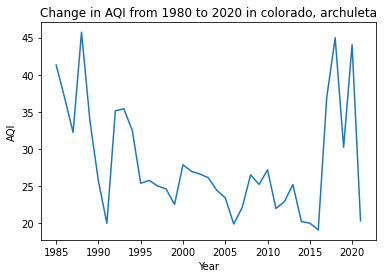

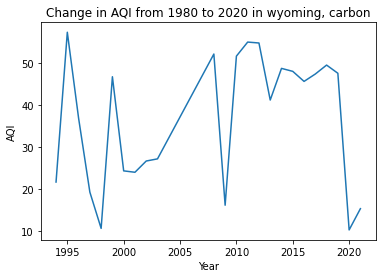

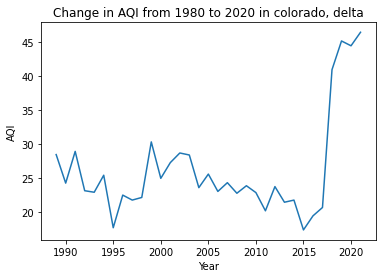

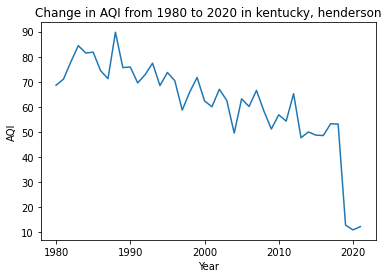

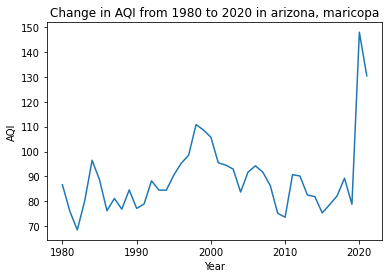

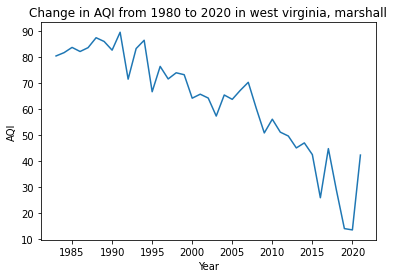

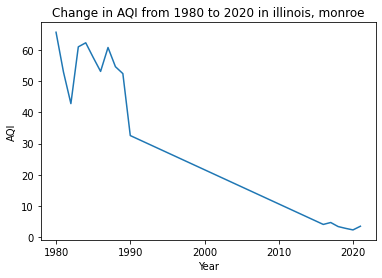

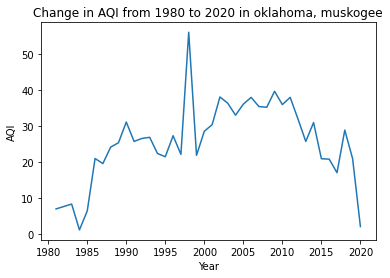

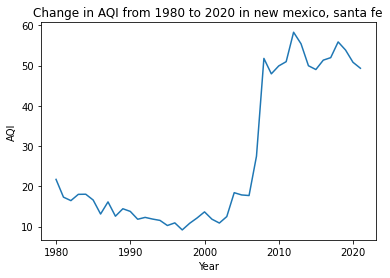

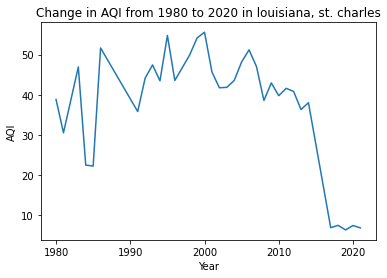

In [ ]:
visualize_data(top_10_data)

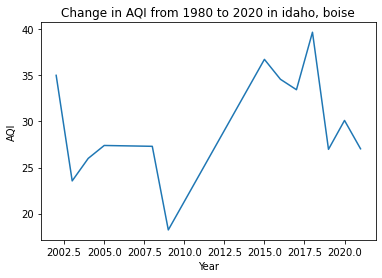

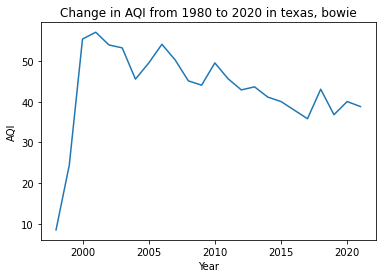

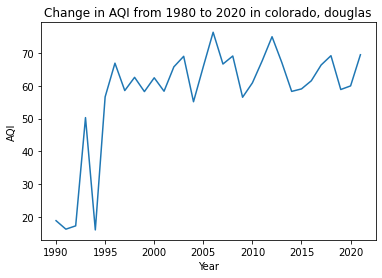

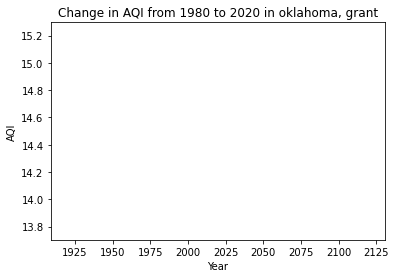

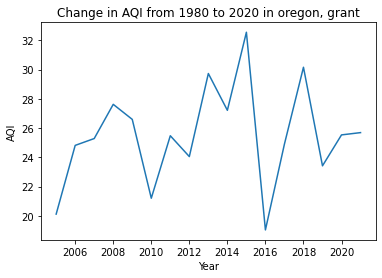

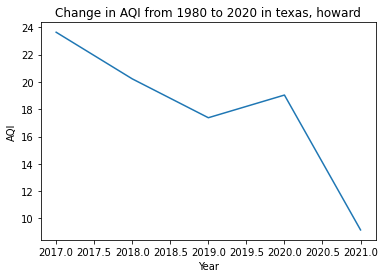

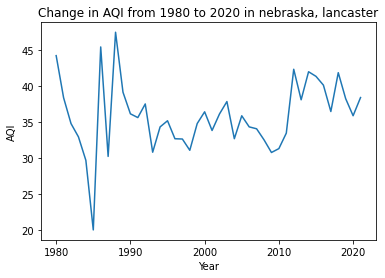

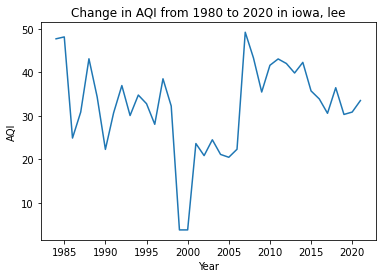

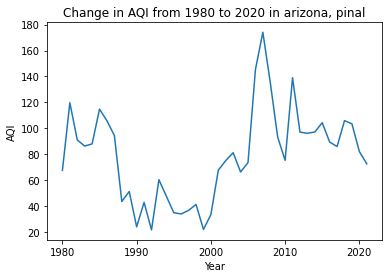

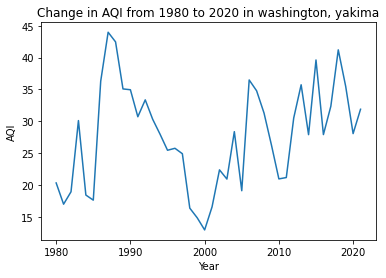

In [ ]:
visualize_data(last_10_data)

## Question 2: Correlation between air quality index and hospitalization

In [ ]:
# Load AQI data as required
que_2_aqi_data = pd.read_csv("/content/drive/MyDrive/Athinia/AQI_data/aqi_data.csv")

In [ ]:
que_2_aqi_data.head()

,state_name,county_name,state_code,county_code,date,aqi,category,defining_parameter,defining_site,number_of_sites_reporting
0,alabama,autauga,1,1,1980-04-05,67,moderate,Ozone,01-001-0002,1
1,alabama,autauga,1,1,1980-04-06,84,moderate,Ozone,01-001-0002,1
2,alabama,autauga,1,1,1980-04-07,61,moderate,Ozone,01-001-0002,1
3,alabama,autauga,1,1,1980-04-08,49,good,Ozone,01-001-0002,1
4,alabama,autauga,1,1,1980-04-09,58,moderate,Ozone,01-001-0002,1


In [ ]:
que_2_cases_data = cases_data
que_2_cases_data.show()

+----------+---------+---------------+-----------+----------------+-----------+------+-----+-------------------+-------------------------------+-------------------+-------+-----------+--------------------+--------------+-------+------+--------+------------------------+----+-----+-----------+
|      date|res_state|state_fips_code|county_name|county_fips_code|  age_group|   sex| race|          ethnicity|case_positive_specimen_interval|case_onset_interval|process|exposure_yn|      current_status|symptom_status|hosp_yn|icu_yn|death_yn|underlying_conditions_yn|year|month| state_name|
+----------+---------+---------------+-----------+----------------+-----------+------+-----+-------------------+-------------------------------+-------------------+-------+-----------+--------------------+--------------+-------+------+--------+------------------------+----+-----+-----------+
|2020-09-01|       ct|             09|  fairfield|           09001|18-49 years|  male|white|non-hispanic/latino|         

In [ ]:
# # Find the minimum date
# min_date = que_2_cases_data.agg(min("case_month")).first()[0]

# # Find the maximum date
# max_date = que_2_cases_data.agg(max("case_month")).first()[0]

# print("Minimum date:", min_date)
# print("Maximum date:", max_date)

Minimum date: 2020-01-01
Maximum date: 2021-10-01


In [ ]:
# Based on above min and max date keep only that start and end date of aqi data to map relation
que_2_aqi_data = que_2_aqi_data[(que_2_aqi_data['date'] >= '2020-01-01') & (que_2_aqi_data['date'] <= '2021-10-01')]

In [ ]:
que_2_cases_data = que_2_cases_data.withColumnRenamed("res_county", "county_name")
que_2_cases_data = que_2_cases_data.withColumnRenamed("state", "state_name")
que_2_cases_data.show(5)

+----------+---------+---------------+-----------+----------------+-----------+------+-----+-------------------+-------------------------------+-------------------+-------+-----------+--------------------+--------------+-------+------+--------+------------------------+----+-----+-----------+
|      date|res_state|state_fips_code|county_name|county_fips_code|  age_group|   sex| race|          ethnicity|case_positive_specimen_interval|case_onset_interval|process|exposure_yn|      current_status|symptom_status|hosp_yn|icu_yn|death_yn|underlying_conditions_yn|year|month| state_name|
+----------+---------+---------------+-----------+----------------+-----------+------+-----+-------------------+-------------------------------+-------------------+-------+-----------+--------------------+--------------+-------+------+--------+------------------------+----+-----+-----------+
|2020-09-01|       ct|             09|  fairfield|           09001|18-49 years|  male|white|non-hispanic/latino|         

In [ ]:
que_2_aqi_data = que_2_aqi_data[['aqi','date','county_name','state_name']]
que_2_aqi_data = spark.createDataFrame(que_2_aqi_data)

In [ ]:
# Averaging month's AQI as we have cases for each month and not for each day

grouped_df = que_2_aqi_data.groupBy(que_2_aqi_data.state_name, que_2_aqi_data.county_name, month(que_2_aqi_data.date).alias("month"), year(que_2_aqi_data.date).alias("year"))

que_2_aqi_data = grouped_df.agg(avg(que_2_aqi_data.aqi).alias("avg_aqi"))

que_2_aqi_data.show(5)

del grouped_df

+----------+-----------+-----+----+------------------+
|state_name|county_name|month|year|           avg_aqi|
+----------+-----------+-----+----+------------------+
|   alabama| tuscaloosa|    9|2020|              29.6|
|   arizona|   maricopa|   12|2020| 84.87096774193549|
|  arkansas|    jackson|    7|2020|              35.4|
|california|      butte|    6|2020|45.333333333333336|
|california|       lake|    6|2020|17.571428571428573|
+----------+-----------+-----+----+------------------+
only showing top 5 rows



In [ ]:
# merging both the AQI and Covid Data

result_df = que_2_aqi_data.join(que_2_cases_data, on=['county_name', 'state_name', 'year', 'month'], how='inner')

result_df.show()

+-----------+----------+----+-----+-----------------+----------+---------+---------------+----------------+----------+------+--------------+-------------------+-------------------------------+-------------------+--------------------+-----------+--------------------+--------------+-------+------+--------+------------------------+
|county_name|state_name|year|month|          avg_aqi|      date|res_state|state_fips_code|county_fips_code| age_group|   sex|          race|          ethnicity|case_positive_specimen_interval|case_onset_interval|             process|exposure_yn|      current_status|symptom_status|hosp_yn|icu_yn|death_yn|underlying_conditions_yn|
+-----------+----------+----+-----+-----------------+----------+---------+---------------+----------------+----------+------+--------------+-------------------+-------------------------------+-------------------+--------------------+-----------+--------------------+--------------+-------+------+--------+------------------------+
| montg

In [ ]:
# Get a DataFrame indicating whether each cell is null or not
null_df = result_df.select([F.when(F.col(c).isNull(), 1).otherwise(0).alias(c) for c in result_df.columns])

# Get the number of null values in each column
null_counts = null_df.agg(*[F.sum(c).alias(c) for c in null_df.columns])

null_counts.show()
del null_df

+-----------+----------+----+-----+-------+----+---------+---------------+----------------+---------+---+--------+---------+-------------------------------+-------------------+--------+-----------+--------------+--------------+--------+--------+--------+------------------------+
|county_name|state_name|year|month|avg_aqi|date|res_state|state_fips_code|county_fips_code|age_group|sex|    race|ethnicity|case_positive_specimen_interval|case_onset_interval| process|exposure_yn|current_status|symptom_status| hosp_yn|  icu_yn|death_yn|underlying_conditions_yn|
+-----------+----------+----+-----+-------+----+---------+---------------+----------------+---------+---+--------+---------+-------------------------------+-------------------+--------+-----------+--------------+--------------+--------+--------+--------+------------------------+
|          0|         0|   0|    0|      0|   0|        0|              0|               0|        0|  0|10337443|        0|                       17559032|    

In [ ]:
result_df = result_df.select(['county_name', 'state_name', 'year', 'month', 'date', 'avg_aqi', 'hosp_yn'])
result_df.show()

+-----------+----------+----+-----+----------+-----------------+-------+
|county_name|state_name|year|month|      date|          avg_aqi|hosp_yn|
+-----------+----------+----+-----+----------+-----------------+-------+
| montgomery|      ohio|2020|   11|2020-11-01|47.43333333333333|     no|
| montgomery|      ohio|2020|   11|2020-11-01|47.43333333333333|     no|
| montgomery|      ohio|2020|   11|2020-11-01|47.43333333333333|   null|
| montgomery|      ohio|2020|   11|2020-11-01|47.43333333333333|     no|
| montgomery|      ohio|2020|   11|2020-11-01|47.43333333333333|     no|
| montgomery|      ohio|2020|   11|2020-11-01|47.43333333333333|     no|
| montgomery|      ohio|2020|   11|2020-11-01|47.43333333333333|   null|
| montgomery|      ohio|2020|   11|2020-11-01|47.43333333333333|     no|
| montgomery|      ohio|2020|   11|2020-11-01|47.43333333333333|   null|
| montgomery|      ohio|2020|   11|2020-11-01|47.43333333333333|   null|
| montgomery|      ohio|2020|   11|2020-11-01|47.43

In [ ]:
result_df.write.format("csv").option("header", "true").save("/content/drive/MyDrive/Athinia/result_df")

In [ ]:
grouped_df = result_df.groupBy(["county_name", "state_name", "year", "month"])\
    .agg(
        F.count("*").alias("total_cases"), 
        F.sum(F.when(F.col("hosp_yn") == "yes", 1).otherwise(0)).alias("hosp_cases")
    )

grouped_df = grouped_df.withColumn("hospitalization_rate", col("hosp_cases")/col("total_cases"))

result_df = result_df.join(grouped_df, on=["county_name", "state_name", "year", "month"], how="inner")

result_df = result_df.dropDuplicates()

result_df.show()
del grouped_df

+-----------+----------+----+-----+----------+------------------+-------+-----------+----------+--------------------+
|county_name|state_name|year|month|      date|           avg_aqi|hosp_yn|total_cases|hosp_cases|hospitalization_rate|
+-----------+----------+----+-----+----------+------------------+-------+-----------+----------+--------------------+
|    baldwin|   alabama|2021|    2|2021-02-01|29.666666666666668|     no|       1526|        19|0.012450851900393184|
|    baldwin|   alabama|2021|    2|2021-02-01|29.666666666666668|   null|       1526|        19|0.012450851900393184|
|    baldwin|   alabama|2021|    2|2021-02-01|29.666666666666668|    yes|       1526|        19|0.012450851900393184|
|    baldwin|   alabama|2021|    3|2021-03-01| 37.87096774193548|   null|        528|        22|0.041666666666666664|
|    baldwin|   alabama|2021|    3|2021-03-01| 37.87096774193548|     no|        528|        22|0.041666666666666664|
|    baldwin|   alabama|2021|    3|2021-03-01| 37.870967

In [ ]:
correlation = result_df.agg(corr("avg_aqi", "hospitalization_rate")).collect()

In [ ]:
correlation[0][0]

0.005723286170596954

## Question 3: Are there any confounding factors you should control for?

In [ ]:
que_3_aqi_data = pd.read_csv("/content/drive/MyDrive/Athinia/AQI_data/aqi_data.csv")
que_3_aqi_data.head()

,state_name,county_name,state_code,county_code,date,aqi,category,defining_parameter,defining_site,number_of_sites_reporting
0,alabama,autauga,1,1,1980-04-05,67,moderate,Ozone,01-001-0002,1
1,alabama,autauga,1,1,1980-04-06,84,moderate,Ozone,01-001-0002,1
2,alabama,autauga,1,1,1980-04-07,61,moderate,Ozone,01-001-0002,1
3,alabama,autauga,1,1,1980-04-08,49,good,Ozone,01-001-0002,1
4,alabama,autauga,1,1,1980-04-09,58,moderate,Ozone,01-001-0002,1


In [ ]:
que_3_cases_data = cases_data
que_3_cases_data.show()

+----------+---------+---------------+-----------+----------------+-----------+------+-----+-------------------+-------------------------------+-------------------+-------+-----------+--------------------+--------------+-------+------+--------+------------------------+----+-----+-----------+
|      date|res_state|state_fips_code|county_name|county_fips_code|  age_group|   sex| race|          ethnicity|case_positive_specimen_interval|case_onset_interval|process|exposure_yn|      current_status|symptom_status|hosp_yn|icu_yn|death_yn|underlying_conditions_yn|year|month| state_name|
+----------+---------+---------------+-----------+----------------+-----------+------+-----+-------------------+-------------------------------+-------------------+-------+-----------+--------------------+--------------+-------+------+--------+------------------------+----+-----+-----------+
|2020-09-01|       ct|             09|  fairfield|           09001|18-49 years|  male|white|               null|         

In [ ]:
que_3_result_df = que_2_aqi_data.join(que_2_cases_data, on=['county_name', 'state_name', 'year', 'month'], how='inner')

In [ ]:
que_3_result_df.show()

+-----------+----------+----+-----+-----------------+----------+---------+---------------+----------------+----------+------+--------------+-------------------+-------------------------------+-------------------+--------------------+-----------+--------------------+--------------+-------+------+--------+------------------------+
|county_name|state_name|year|month|          avg_aqi|      date|res_state|state_fips_code|county_fips_code| age_group|   sex|          race|          ethnicity|case_positive_specimen_interval|case_onset_interval|             process|exposure_yn|      current_status|symptom_status|hosp_yn|icu_yn|death_yn|underlying_conditions_yn|
+-----------+----------+----+-----+-----------------+----------+---------+---------------+----------------+----------+------+--------------+-------------------+-------------------------------+-------------------+--------------------+-----------+--------------------+--------------+-------+------+--------+------------------------+
| montg

In [ ]:
que_3_result_df = que_3_result_df.select(['county_name', 'state_name', 'year', 'month', 'date', 'avg_aqi', 'hosp_yn', 'age_group', 'sex', 'ethnicity'])
que_3_result_df.show()

In [ ]:
grouped_df = que_3_result_df.groupBy(["county_name", "state_name", "year", "month", 'age_group'])\
    .agg(
        F.count("*").alias("total_cases"), 
        F.sum(F.when(F.col("hosp_yn") == "yes", 1).otherwise(0)).alias("hosp_cases")
    )

grouped_df = grouped_df.withColumn("hospitalization_rate", F.col("hosp_cases")/F.col("total_cases"))

que_3_result_df = que_3_result_df.join(grouped_df, on=["county_name", "state_name", "year", "month", 'age_group'], how="inner")

que_3_result_df = que_3_result_df.dropDuplicates()

que_3_result_df.show()
del grouped_df

+-------------+--------------+----+-----+-----------+----------+-----------------+-------+------+-------------------+-----------+----------+--------------------+
|  county_name|    state_name|year|month|  age_group|      date|          avg_aqi|hosp_yn|   sex|          ethnicity|total_cases|hosp_cases|hospitalization_rate|
+-------------+--------------+----+-----+-----------+----------+-----------------+-------+------+-------------------+-----------+----------+--------------------+
|     guernsey|          ohio|2021|    1| 0-17 years|2021-01-01|              9.0|     no|  male|non-hispanic/latino|         76|         3|0.039473684210526314|
|     guernsey|          ohio|2021|    1| 0-17 years|2021-01-01|              9.0|    yes|  male|non-hispanic/latino|         76|         3|0.039473684210526314|
|        henry|       indiana|2020|    6|50-64 years|2020-06-01|             32.5|     no|female|non-hispanic/latino|         16|         1|              0.0625|
|        henry|       indian

In [ ]:
correlation_que_3 = que_3_result_df.agg(corr("avg_aqi", "hospitalization_rate")).collect()

In [ ]:
correlation_que_3[0][0]

0.046133108684775194